# Example 3 (Burgers): MAP estimation   

In [51]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [52]:
# Import module. 
using Revise
using PriorNormalization

In [53]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant to then use AD  
using CairoMakie # for plots 
using JLD2 # for saving and loading results
using LinearAlgebra # to represent the identity matrix as "I" 
using Optim # for ML and MAP estimation 
using Optimization # for formulating optimization problem 
using OptimizationOptimisers # for ADAM optimizer
using OrdinaryDiffEq # for time integration
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 
using Random # for generating random noise 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions # for the prior-normalizing transport map
using Trixi # for setting up the semi-discretization 

## Define the data model 

In [54]:
# Problem parameters 
σ² = 1.0*1e-2 # noise variance  
N = 100 # number of points 
M = Int64(ceil(N/5)) # number of observational data 
Random.seed!(123) # Setting the random seed 

TaskLocalRNG()

In [55]:
## Initial data and solution 

# Piecewise constant initial data 
function initial_condition_shock(x, t, equation::InviscidBurgersEquation1D)
    RealT = eltype(x)
    scalar = abs( x[1] - 0.5 ) < 0.25 ? convert(RealT, 1.0f0) : convert(RealT, 0.0f0)

    return SVector(scalar)
end

# Reference solution at time T=0.25 
function ref_solution(x)
    
    N = length(x)
    sol_ref = zeros(N,1) 
    
    for n in 1:N 
        if x[n] >= 0.25 && x[n] < 0.5 
            sol_ref[n] = 4*(x[n] - 0.25) 
        elseif x[n] >= 0.5 && x[n] < 0.875 
            sol_ref[n] = 1
        end
    end

    return sol_ref
end

ref_solution (generic function with 1 method)

In [56]:
## Semidiscretization of the (inviscid) Burgers' equation

equations = InviscidBurgersEquation1D() 

initial_condition = initial_condition_shock

D_upw = upwind_operators(SummationByPartsOperators.Mattsson2017,
                         derivative_order = 1,
                         accuracy_order = 4,
                         xmin = -1.0, xmax = 1.0,
                         N = N)
flux_splitting = splitting_lax_friedrichs
solver = FDSBP(D_upw,
               surface_integral = SurfaceIntegralUpwind(flux_splitting),
               volume_integral = VolumeIntegralUpwind(flux_splitting))

coordinates_min = 0.0
coordinates_max = 1.0
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 0,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 1                   │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_shock                                          │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [57]:
## Get the nodal values of the true initial condition and the associated solution 

# Run the simulation 
T = 0.25
tspan = (0.0, T)
ode = semidiscretize(semi, tspan)
sol = solve(ode, SSPRK43())

# Grid points 
grid_u = LinRange(coordinates_min, coordinates_max, N)
grid_b = LinRange(coordinates_min, coordinates_max, M)    

# Extract the initial data  
u0 = sol(0.0) 
# Extract the numerical solution   
uT_num = sol(T)
# Exact solution 
uT_ref = ref_solution(grid_u)

# Generate the observational data 
#obsData_full = uT_num .+ sqrt(σ²)*randn(length(uT_num)) 
obsData_full = uT_ref .+ sqrt(σ²)*randn(length(uT_ref)) 
obsData = obsData_full[1:Int64(ceil(N/M)):end]

20-element Vector{Float64}:
  0.08082879284649669
  0.022981869805186763
  0.12192815097319654
 -0.08900766562698115
  0.20081126248520312
  0.05704871052513616
  0.4023844850955033
  0.28523930705601064
  0.6615987487062823
  0.7074733730284238
  0.8617107722308261
  1.0758746890863273
  0.7474389459416231
  0.8534389143119507
  1.0183639757280603
  1.114809342282114
  1.0566026075396748
  0.957509472426523
 -0.003170723035024594
 -0.06787747615011162

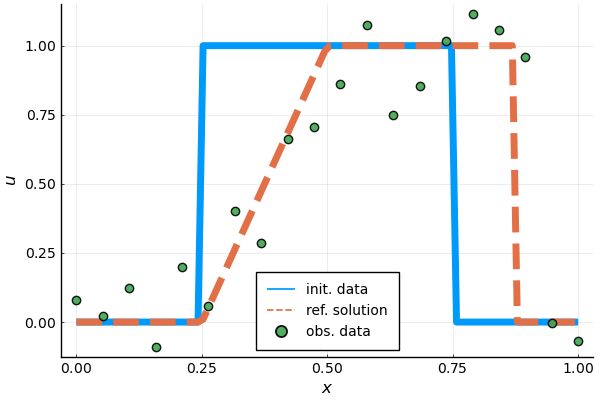

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataRef.pdf"

In [58]:
## Plot the init. data, ref. solution, and obs. data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_ref, label="ref. solution", lw=5, ls=:dash)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataRef.pdf"
)
savefig(output_filename)

## Forward operator

Below, we take the initial condition and solve Burgers' equation with it.

In [59]:
function forward_operator( v0 )
    
    # Set the initial data equal to u0
    sol_integrator = init(ode, SSPRK43())
    reinit!(sol_integrator, v0)

    # Solve Burgers' equation with the changed initial data 
    sol_aux = solve!(sol_integrator);
    vT_full =  sol_aux(0.25)
    vT = Vector(vT_full[1:Int64(ceil(N/M)):end])
    
    return vT
    
end

forward_operator (generic function with 1 method)

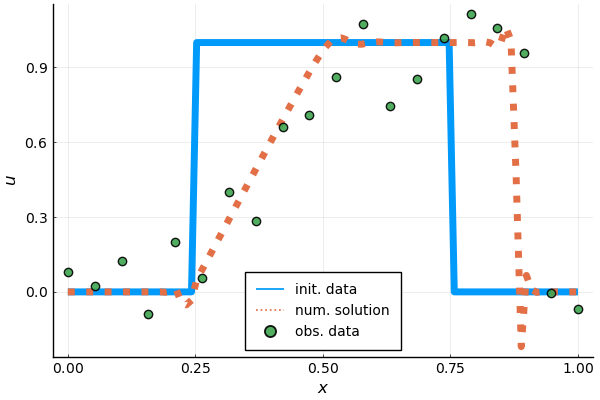

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataNum.pdf"

In [60]:
## Plot the initial data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_num, label="num. solution", lw=5, ls=:dot)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataNum.pdf"
)
#savefig(output_filename)

## The sparsifying transform

In [61]:
# Invertible finite difference matrix
aux = ones(N) * [-1.0, 1.0]'
L = spzeros(Float64, N, N)
L[2:end,:] = spdiagm(0=>-1*ones(N), 1=>ones(N))[1:N-1,1:N]
L[1,1] = 1 

display(L)

# Change coordinates to promote sparsity in v = L*u 
forwardOp( v ) = (1/sqrt(σ²)) * forward_operator( L\v ) 

# Whitening of observational data 
b = (1/sqrt(σ²)) * obsData

100×100 SparseMatrixCSC{Float64, Int64} with 199 stored entries:
⎡⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⎦

20-element Vector{Float64}:
  0.8082879284649669
  0.22981869805186764
  1.2192815097319654
 -0.8900766562698115
  2.008112624852031
  0.5704871052513616
  4.023844850955033
  2.8523930705601064
  6.6159874870628235
  7.074733730284239
  8.617107722308262
 10.758746890863273
  7.474389459416231
  8.534389143119508
 10.183639757280602
 11.14809342282114
 10.56602607539675
  9.57509472426523
 -0.03170723035024594
 -0.6787747615011163

## Generic models for the original and prior-normalized problem

In [62]:
# Different parameters of  generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

In [63]:
# Define the log-posterior density 
function logpdf_original(θ, v; forwardOp, b, r, β, ϑ)    
    if any(θ .<= 0) # any non-positive element? 
        logpdf = -Inf 
    else
        logpdf = -0.5*norm( forwardOp(v) - b )^2 - 
            0.5*sum( v.^2 ./ θ ) - 
            sum( (θ/ϑ).^r ) + 
            (r*β-1.5)*sum( log.(θ) )
    end
    
    return logpdf
end

logpdf_original (generic function with 1 method)

In [64]:
# Define the posterior density 
function logpdf_priorNormalized(τ, w; forwardOp, b, r, β, ϑ, Φ::Function) 
    
    # Get value of log-prior
    log_prior = -0.5*sum( w.^2 + τ.^2 )
    
    # Get z-value by using transport MAP 
    N = length(w)
    v = zeros(N)
    for n in 1:N
        v[n] = priorNormalizing_KR_inv_tu( w[n], τ[n]; r, β, ϑ, Φ )
    end
    
    # Get the log of the transformed likelihood 
    log_likelihood = -0.5*norm( forwardOp(v) - b )^2

    # Get log-posterior 
    logpdf = log_prior + log_likelihood
    
    return logpdf
end

logpdf_priorNormalized (generic function with 1 method)

## MAP estimation for model with $r=-1$

### Initiate the models

In [65]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = Interval(-5, 5)
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [66]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation  
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(),
    Optim.Options(iterations = 100_000, time_limit = 7200.0, 
    show_trace = true, show_every = 100)
)

Iter     Function value   Gradient norm 
     0    -1.277819e+03     2.378646e+03
 * time: 0.0008499622344970703
   100    -2.051186e+03     3.915734e+03
 * time: 64.0352680683136
   200    -2.053462e+03     5.442876e+02
 * time: 116.98345804214478
   300    -2.055307e+03     1.486111e+02
 * time: 171.2086341381073
   400    -2.056259e+03     4.828928e+02
 * time: 222.3529191017151
   500    -2.057184e+03     1.370672e+03
 * time: 273.916188955307
   600    -2.062354e+03     7.184956e+02
 * time: 321.09736609458923
   700    -2.062898e+03     3.496668e+02
 * time: 370.8961441516876
   800    -2.064347e+03     6.807619e+02
 * time: 424.778596162796
   900    -2.071403e+03     2.425651e+03
 * time: 478.8838701248169
  1000    -2.080006e+03     1.123387e+03
 * time: 530.0351040363312
  1100    -2.084729e+03     3.347134e+03
 * time: 584.2467050552368
  1200    -2.088637e+03     4.178915e+03
 * time: 638.7451751232147
  1300    -2.093160e+03     1.762695e+03
 * time: 699.6174600124359
  14

 * Status: failure (exceeded time limit of 7200.0)

 * Candidate solution
    Final objective value:     -2.176317e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.41e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.65e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.52e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-07 ≰ 0.0e+00
    |g(x)|                 = 4.32e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   7202  (vs limit 7200)
    Iterations:    5360
    f(x) calls:    15938
    ∇f(x) calls:   15938


In [79]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
v_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
u_MAP = L \ v_MAP

# Save the vectors to a file
@save "data/Burgers_model$(model_nr)_MAP_original.jld2" θ_MAP v_MAP

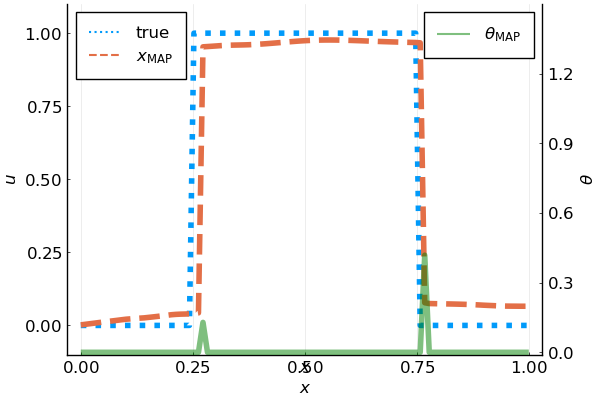

In [81]:
# Illustrate the MAP estimate of the target posterior
pyplot()

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, grid_u, u0; label="true", lw=4, ls=:dot )
# Add MAP estimate for x 
Plots.plot!( p, grid_u, u_MAP; label=L"x_{\rm MAP}", lw=4, ls=:dash )

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-0.1, 1.1],
    xlabel=L"x", ylabel=L"u", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Add MAP estimate for θ  
Plots.plot!( p_twin, grid_u, θ_MAP; label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-1e-2, 1.5],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_MAP_original.pdf"
)
PyPlot.savefig(output_filename)

### MAP estimate for the prior-normalized posterior

In [69]:
# Initial guess for the optimization (τ and v)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(),
    Optim.Options(iterations = 100_000, time_limit = 7200.0, 
    show_trace = true, show_every = 100)
)

Iter     Function value   Gradient norm 
     0     4.379863e+02     1.339746e+01
 * time: 0.00017309188842773438
   100     2.550323e+01     2.909952e-01
 * time: 163.16176104545593
   200     2.550106e+01     2.912941e-02
 * time: 343.0352921485901
   300     2.550108e+01     9.807297e-02
 * time: 602.3984999656677
   400     2.550109e+01     2.002147e-02
 * time: 4524.6196801662445
   500     2.550109e+01     2.616597e-02
 * time: 4718.373929023743
   600     2.550113e+01     1.731992e-02
 * time: 4923.742379188538
   700     2.550112e+01     1.080680e-01
 * time: 5115.798976182938
   800     2.550114e+01     3.239131e-02
 * time: 5305.10453414917
   900     2.550114e+01     4.412979e-02
 * time: 5479.945266008377
  1000     2.550113e+01     1.358551e-01
 * time: 5654.751922130585
  1100     2.550113e+01     1.756387e-01
 * time: 5839.234538078308
  1200     2.550114e+01     1.859877e-02
 * time: 6036.922872066498


 * Status: failure (exceeded time limit of 7200.0)

 * Candidate solution
    Final objective value:     2.550113e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.17e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.05e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.88e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.39e-09 ≰ 0.0e+00
    |g(x)|                 = 2.56e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   8068  (vs limit 7200)
    Iterations:    1277
    f(x) calls:    3815
    ∇f(x) calls:   3815


In [70]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
w_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
u_MAP = L \ w_MAP

# Save the vectors to a file
@save "data/Burgers_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP w_MAP

In [71]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
v_pullback = zeros(Float64,N)
u_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for n in 1:N 
    τ = τ_MAP[n]
    w = w_MAP[n]
    v_pullback[n], θ_pullback[n] = priorNormalizing_KR_inv( w, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

# Get the pullback values for x 
u_pullback = L \ v_pullback

100-element Vector{Float64}:
  0.0038091837905137793
  0.006303727941212169
  0.009114693261401312
  0.0119046920850005
  0.014636678238238162
  0.017314814149087643
  0.01990684380839789
  0.022522384678868346
  0.025237328307389766
  0.02769258930347404
  ⋮
 -0.010642838002206629
 -0.011370291349475203
 -0.012089978134569971
 -0.012842732495873201
 -0.013556442347147769
 -0.01367101915790136
 -0.013392627397356693
 -0.013139565431250765
 -0.012835616767968164

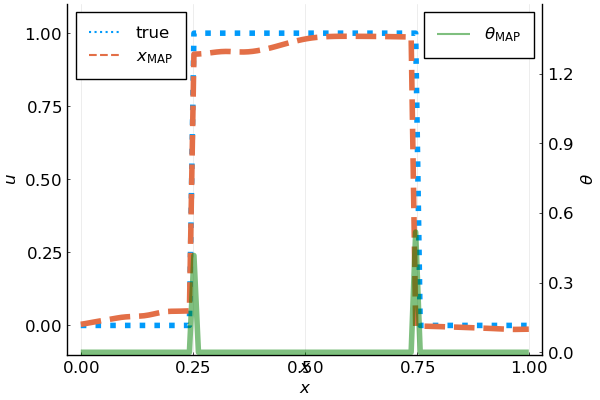

In [78]:
# Illustrate the MAP estimate of the target posterior
pyplot()

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, grid_u, u0; label="true", lw=4, ls=:dot )
# Add MAP estimate for x 
Plots.plot!( p, grid_u, u_pullback; label=L"x_{\rm MAP}", lw=4, ls=:dash )

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-0.1, 1.1],
    xlabel=L"x", ylabel=L"u", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Add MAP estimate for θ  
Plots.plot!( p_twin, grid_u, θ_pullback; label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-1e-2, 1.5],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_MAP_priorNormalized.pdf"
)
PyPlot.savefig(output_filename)